In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import cv2
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T

# torch.multiprocessing.set_start_method(method='spawn', force=True)

sys.path.append('../')

from scipy import misc
from PIL import Image
from tqdm import tqdm
from omegaconf import OmegaConf, DictConfig
from evaluation import eval_utils as eu

/tmp/ipykernel_64482/2195629255.py:21: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [2]:
def contract_to_unisphere(
    x: torch.Tensor,
    ord: float = 2,
    eps: float = 1e-6,
    derivative: bool = False,
    cdf_lb: float = 0.1,
    num_bins: int = 1000,
):  
    x_pdf, x_pos = torch.histogram(x[:, 0].cpu(), bins=num_bins)
    y_pdf, y_pos = torch.histogram(x[:, 1].cpu(), bins=num_bins)
    z_pdf, z_pos = torch.histogram(x[:, 2].cpu(), bins=num_bins)
    x_cdf, x_pos = torch.cumsum(x_pdf, dim=0) / x.shape[0], x_pos[:-1]
    y_cdf, y_pos = torch.cumsum(y_pdf, dim=0) / x.shape[0], y_pos[:-1]
    z_cdf, z_pos = torch.cumsum(z_pdf, dim=0) / x.shape[0], z_pos[:-1]

    aabb = torch.tensor([
        x_pos[x_cdf > cdf_lb].min(),
        y_pos[y_cdf > cdf_lb].min(),
        z_pos[z_cdf > cdf_lb].min(),
        x_pos[x_cdf > 1 - cdf_lb].min(),
        y_pos[y_cdf > 1 - cdf_lb].min(),
        z_pos[z_cdf > 1 - cdf_lb].min(),
    ], device=x.device)
    aabb_min, aabb_max = torch.split(aabb, aabb.shape[0] // 2, dim=-1)
    x = (x - aabb_min) / (aabb_max - aabb_min)
    x = x * 2 - 1  # aabb is at [-1, 1]
    mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
    mask = mag.squeeze(-1) > 1

    if derivative:
        dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
            1 / mag**3 - (2 * mag - 1) / mag**4
        )
        dev[~mask] = 1.0
        dev = torch.clamp(dev, min=eps)
        return dev
    else:
        x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
        x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
        return x

def get_flowid(frames, flows, rgb_threshold=0.01):
    N, _, H, W = frames.shape
    flow_ids = torch.ones_like(frames[:, 0], dtype=torch.int64) * -1
    flow_ids[0] = torch.arange(H * W).view(H, W)
    last_id = H * W

    grid_y, grid_x = torch.meshgrid(torch.arange(H), torch.arange(W))
    grid_y = grid_y.to(device=frames.device)
    grid_x = grid_x.to(device=frames.device)
    diff_threshold = frames.max().item() * rgb_threshold
    for i in tqdm(range(1, N), desc="Assigning flow ids"):
        x = (grid_x + flows[i-1, 0]).round().to(torch.int64)
        y = (grid_y + flows[i-1, 1]).round().to(torch.int64)
        mask = (x >= 0) & (x < W) & (y >= 0) & (y < H)
        # cut off flow when error is significant
        diff_mask = (frames[i, :, y[mask], x[mask]] - frames[i-1, :, grid_y[mask], grid_x[mask]]).abs().max(dim=0).values < diff_threshold
        flow_ids[i, y[mask][diff_mask], x[mask][diff_mask]] = flow_ids[i-1, grid_y[mask][diff_mask], grid_x[mask][diff_mask]]

        unassigned = (flow_ids[i] == -1)
        flow_ids[i, unassigned] = last_id + torch.arange(unassigned.sum(), device=frames.device)
        last_id += unassigned.sum()
    
    return flow_ids

def voxelization(flow_ids, in_feats_rgb, in_feats_coord, voxel_size, rgb_vox_size=2/255, xyz_min=None, contract=False):
    with torch.no_grad():
        # automatically determine the voxel size
        _, unq_inv_t, _ = torch.unique(flow_ids, return_inverse=True, return_counts=True, dim=0)
        if voxel_size is None:
            print("[INFO] Scatter with Time Dimention.")
            feats_rgb = torch_scatter.scatter(in_feats_rgb, unq_inv_t, dim=0, reduce='mean')
            unq_inv = unq_inv_t
        else:
            print("[INFO] Scatter with Time&Spatial Dimention.")
            feats_rgb = torch_scatter.scatter(in_feats_rgb, unq_inv_t, dim=0, reduce='mean')
            feats_coord = torch_scatter.scatter(in_feats_coord, unq_inv_t, dim=0, reduce='mean')

            # contract to unit sphere
            # decide aabb according to density
            if contract:
                feats_coord = contract_to_unisphere(feats_coord, ord=torch.inf)
            if xyz_min is None:
                xyz_min = torch.min(feats_coord, dim=0).values
            voxel_size = torch.tensor([voxel_size] * 3, dtype=feats_coord.dtype, device=feats_coord.device)
            voxel_index = torch.div(feats_coord - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
            voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2
            voxel_coords = torch.cat([voxel_coords, torch.div(feats_rgb, rgb_vox_size, rounding_mode='floor')], dim=1)
            feats_coord, unq_inv_xyz, _ = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
            feats_rgb = torch_scatter.scatter(feats_rgb, unq_inv_xyz, dim=0, reduce='mean')

            unq_inv = unq_inv_xyz[unq_inv_t]

        print(f"Total number of unique voxels: {feats_rgb.shape[0]} / {flow_ids.shape[0]}")

        return unq_inv

def warp_flow(frames, past_flows):
    
    N, _, H, W = frames.shape
    flow_new = past_flows[:, :2].clone()
    flow_new[:, 0, :, :] += torch.arange(W, device=flow_new.device)
    flow_new[:, 1, :, :] += torch.arange(H, device=flow_new.device)[:, None]
    # resides flow_new to [-1, 1]
    flow_new[:, 0] = (flow_new[:, 0] / (W - 1) - 0.5) * 2
    flow_new[:, 1] = (flow_new[:, 1] / (H - 1) - 0.5) * 2
    frame_warp = F.grid_sample(frames, flow_new.permute(0, 2, 3, 1), mode='bicubic', padding_mode='zeros', align_corners=True)

    return frame_warp

def compute_fwdbwd_mask(fwd_flow, bwd_flow, alpha=0.1):

    bwd2fwd_flow = warp_flow(bwd_flow, fwd_flow)
    fwd_lr_error = torch.linalg.norm(fwd_flow + bwd2fwd_flow, dim=1)
    fwd_mask = fwd_lr_error < alpha * (torch.linalg.norm(fwd_flow, dim=1) + torch.linalg.norm(bwd2fwd_flow, dim=1)) + alpha

    fwd2bwd_flow = warp_flow(fwd_flow, bwd_flow)
    bwd_lr_error = torch.linalg.norm(bwd_flow + fwd2bwd_flow, dim=1)
    bwd_mask = bwd_lr_error < alpha * (torch.linalg.norm(bwd_flow, dim=1) + torch.linalg.norm(fwd2bwd_flow, dim=1)) + alpha

    return fwd_mask, bwd_mask

def get_mask_bwds(input, flows, past_flows, device='cuda', dtype=torch.float16):

    if isinstance(input, str):
        pil_list = eu.video_to_pil_list(input)
        org_images = torch.concat([eu.load_image(pil, device, dtype) for pil in pil_list], dim=0) / 255.0
    else:
        org_images = input

    mask_bwds = torch.ones_like(org_images[:, 0], dtype=torch.bool)
    _, mask_bwds[1:] = compute_fwdbwd_mask(flows[:-1], past_flows[1:])
    org_images_warp = warp_flow(org_images[:-1], past_flows[1:])
    mask_bwds[1:] &= (org_images_warp - org_images[1:]).abs().max(dim=1).values < org_images.max().item() * 0.1
    mask_bwds = mask_bwds[:, None, ...].repeat(1, 3, 1, 1)

    return mask_bwds

In [3]:
from typing import List, Optional, Tuple, Union
from torch import Tensor
from pytorch_msssim import ms_ssim
from pytorch_msssim.ssim import gaussian_filter, _fspecial_gauss_1d

def _relaxed_ssim(
    X: Tensor,
    Y: Tensor,
    data_range: float,
    win: Tensor,
    l_activate_func=lambda x: x,
    cs_activate_func=lambda x: x,
    flatten: bool = True,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03)
) -> Tuple[Tensor, Tensor]:
    r""" Calculate ssim index for X and Y

    Args:
        X (torch.Tensor): images
        Y (torch.Tensor): images
        data_range (float or int): value range of input images. (usually 1.0 or 255)
        win (torch.Tensor): 1-D gauss kernel
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: ssim results.
    """
    K1, K2 = K
    # batch, channel, [depth,] height, width = X.shape
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    win = win.to(X.device, dtype=X.dtype)

    mu1 = gaussian_filter(X, win)
    mu2 = gaussian_filter(Y, win)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (gaussian_filter(X * X, win) - mu1_sq)
    sigma2_sq = compensation * (gaussian_filter(Y * Y, win) - mu2_sq)
    sigma12 = compensation * (gaussian_filter(X * Y, win) - mu1_mu2)

    cs_map = cs_activate_func((2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))  # set alpha=beta=gamma=1
    ssim_map = l_activate_func((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    if flatten:
        ssim_per_channel = torch.flatten(ssim_map, 2).mean(-1)
        cs = torch.flatten(cs_map, 2).mean(-1)
        return ssim_per_channel, cs
    else:
        return ssim_map, cs_map

def relaxed_ms_ssim(
    X: Tensor,
    Y: Tensor,
    l_activate_func=lambda x: x,
    cs_activate_func=lambda x: x,
    start_level: int = 0,
    data_range: float = 255,
    size_average: bool = True,
    win_size: int = 11,
    win_sigma: float = 1.5,
    win: Optional[Tensor] = None,
    weights: Optional[List[float]] = None,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03)
) -> Tensor:
    r""" interface of ms-ssim
    Args:
        X (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        Y (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        weights (list, optional): weights for different levels
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
    Returns:
        torch.Tensor: ms-ssim results
    """
    if not X.shape == Y.shape:
        raise ValueError(f"Input images should have the same dimensions, but got {X.shape} and {Y.shape}.")

    for d in range(len(X.shape) - 1, 1, -1):
        X = X.squeeze(dim=d)
        Y = Y.squeeze(dim=d)

    #if not X.type() == Y.type():
    #    raise ValueError(f"Input images should have the same dtype, but got {X.type()} and {Y.type()}.")

    if len(X.shape) == 4:
        avg_pool = F.avg_pool2d
    elif len(X.shape) == 5:
        avg_pool = F.avg_pool3d
    else:
        raise ValueError(f"Input images should be 4-d or 5-d tensors, but got {X.shape}")

    if win is not None:  # set win_size
        win_size = win.shape[-1]

    if not (win_size % 2 == 1):
        raise ValueError("Window size should be odd.")

    smaller_side = min(X.shape[-2:])
    assert smaller_side > (win_size - 1) * (
        2 ** 4
    ), "Image size should be larger than %d due to the 4 downsamplings in ms-ssim" % ((win_size - 1) * (2 ** 4))

    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    weights_tensor = X.new_tensor(weights)

    if win is None:
        win = _fspecial_gauss_1d(win_size, win_sigma)
        win = win.repeat([X.shape[1]] + [1] * (len(X.shape) - 1))

    levels = weights_tensor.shape[0]
    mcs = []
    for i in range(levels):
        if i >= start_level:
            ssim_per_channel, cs = _relaxed_ssim(X, Y, l_activate_func=l_activate_func, cs_activate_func=cs_activate_func, win=win, data_range=data_range, K=K)
        else:
            ssim_per_channel = torch.ones_like(X[:, :, 0, 0])
            cs = torch.ones_like(X[:, :, 0, 0])

        if i < levels - 1:
            mcs.append(torch.relu(cs))
            padding = [s % 2 for s in X.shape[2:]]
            X = avg_pool(X, kernel_size=2, padding=padding)
            Y = avg_pool(Y, kernel_size=2, padding=padding)

    ssim_per_channel = torch.relu(ssim_per_channel)  # type: ignore  # (batch, channel)
    mcs_and_ssim = torch.stack(mcs + [ssim_per_channel], dim=0)  # (level, batch, channel)
    ms_ssim_val = torch.prod(mcs_and_ssim ** weights_tensor.view(-1, 1, 1), dim=0)

    if size_average:
        return ms_ssim_val.mean()
    else:
        return ms_ssim_val.mean(1)

def _weighted_ssim(
    X: Tensor,
    Y: Tensor,
    Z: Tensor,
    data_range: float,
    win: Tensor,
    l_activate_func=lambda x: x,
    cs_activate_func=lambda x: x,
    flatten: bool = True,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03)
) -> Tuple[Tensor, Tensor]:
    r""" Calculate ssim index for X and Y

    Args:
        X (torch.Tensor): source images
        Y (torch.Tensor): target images
        Z (torch.Tensor): reference images
        data_range (float or int): value range of input images. (usually 1.0 or 255)
        win (torch.Tensor): 1-D gauss kernel
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: ssim results.
    """
    K1, K2 = K
    # batch, channel, [depth,] height, width = X.shape
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    win = win.to(X.device, dtype=X.dtype)

    mu1 = gaussian_filter(X, win)
    mu2 = gaussian_filter(Y, win)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (gaussian_filter(X * X, win) - mu1_sq)
    sigma2_sq = compensation * (gaussian_filter(Y * Y, win) - mu2_sq)
    sigma12 = compensation * (gaussian_filter(X * Y, win) - mu1_mu2)

    cs_map = cs_activate_func((2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2))  # set alpha=beta=gamma=1
    ssim_map = l_activate_func((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    with torch.no_grad():
        mu3 = gaussian_filter(Z, win)
        mu3_sq = mu3.pow(2)
        mu3_mu2 = mu3 * mu2
        sigma3_sq = compensation * (gaussian_filter(Z * Z, win) - mu3_sq)
        sigma32 = compensation * (gaussian_filter(Z * Y, win) - mu3_mu2)
        cs_map_w = torch.flatten(cs_activate_func((2 * sigma32 + C2) / (sigma3_sq + sigma2_sq + C2)), 2)  # set alpha=beta=gamma=1

    if flatten:
        # more difference with ref, less cs_map_w, lower loss, higher ssim
        ssim_per_channel = (1 - torch.flatten(1 - ssim_map, 2) * cs_map_w).mean(-1)
        cs = (1 - torch.flatten(1 - cs_map, 2) * cs_map_w).mean(-1)
        return ssim_per_channel, cs
    else:
        return ssim_map, cs_map

def weighted_ms_ssim(
    X: Tensor,
    Y: Tensor,
    Z: Tensor,
    l_activate_func=lambda x: x,
    cs_activate_func=lambda x: x,
    start_level: int = 0,
    data_range: float = 255,
    size_average: bool = True,
    win_size: int = 11,
    win_sigma: float = 1.5,
    win: Optional[Tensor] = None,
    weights: Optional[List[float]] = None,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03)
) -> Tensor:
    r""" interface of ms-ssim
    Args:
        X (torch.Tensor): a batch of source images, (N,C,[T,]H,W)
        Y (torch.Tensor): a batch of target images, (N,C,[T,]H,W)
        Z (torch.Tensor): a batch of reference images, (N,C,[T,]H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        weights (list, optional): weights for different levels
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
    Returns:
        torch.Tensor: ms-ssim results
    """
    if not X.shape == Y.shape:
        raise ValueError(f"Input images should have the same dimensions, but got {X.shape} and {Y.shape}.")

    for d in range(len(X.shape) - 1, 1, -1):
        X = X.squeeze(dim=d)
        Y = Y.squeeze(dim=d)

    #if not X.type() == Y.type():
    #    raise ValueError(f"Input images should have the same dtype, but got {X.type()} and {Y.type()}.")

    if len(X.shape) == 4:
        avg_pool = F.avg_pool2d
    elif len(X.shape) == 5:
        avg_pool = F.avg_pool3d
    else:
        raise ValueError(f"Input images should be 4-d or 5-d tensors, but got {X.shape}")

    if win is not None:  # set win_size
        win_size = win.shape[-1]

    if not (win_size % 2 == 1):
        raise ValueError("Window size should be odd.")

    smaller_side = min(X.shape[-2:])
    assert smaller_side > (win_size - 1) * (
        2 ** 4
    ), "Image size should be larger than %d due to the 4 downsamplings in ms-ssim" % ((win_size - 1) * (2 ** 4))

    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    weights_tensor = X.new_tensor(weights)

    if win is None:
        win = _fspecial_gauss_1d(win_size, win_sigma)
        win = win.repeat([X.shape[1]] + [1] * (len(X.shape) - 1))

    levels = weights_tensor.shape[0]
    mcs = []
    for i in range(levels):
        if i >= start_level:
            ssim_per_channel, cs = _weighted_ssim(X, Y, Z, l_activate_func=l_activate_func, cs_activate_func=cs_activate_func, win=win, data_range=data_range, K=K)
        else:
            ssim_per_channel = torch.ones_like(X[:, :, 0, 0])
            cs = torch.ones_like(X[:, :, 0, 0])

        if i < levels - 1:
            mcs.append(torch.relu(cs))
            padding = [s % 2 for s in X.shape[2:]]
            X = avg_pool(X, kernel_size=2, padding=padding)
            Y = avg_pool(Y, kernel_size=2, padding=padding)
            Z = avg_pool(Z, kernel_size=2, padding=padding)

    ssim_per_channel = torch.relu(ssim_per_channel)  # type: ignore  # (batch, channel)
    mcs_and_ssim = torch.stack(mcs + [ssim_per_channel], dim=0)  # (level, batch, channel)
    ms_ssim_val = torch.prod(mcs_and_ssim ** weights_tensor.view(-1, 1, 1), dim=0)

    if size_average:
        return ms_ssim_val.mean()
    else:
        return ms_ssim_val.mean(1)

## 0. Data loading

In [4]:
output_dir = "../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None"
config = OmegaConf.load(os.path.join(output_dir, 'config.yaml'))

if config.data.scene_type.lower() == "sceneflow":
    from utils.dataparsers import SceneFlowDataParser
    config.data.data_dir = os.path.join('../', config.data.data_dir)  # update relative path for notebook
    data_parser = SceneFlowDataParser(config.data, config.device, dtype=torch.float32)
    # data_parser.voxel_size, data_parser.use_raft = 0.01, False
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids)
elif config.data.scene_type.lower() == "video":
    from utils.dataparsers import VideoDataParser
    config.data.rgb_path = os.path.join('../', config.data.rgb_path).replace('agirobot', 'agibot')  # update relative path for notebook
    data_parser = VideoDataParser(config.data, config.device, dtype=torch.float32)
    frame_ids = eu.get_frame_ids(config.generation.frame_range, config.generation.frame_ids)
    org_frames, _, _, flows, past_flows, mask_bwds =  data_parser.load_video(frame_ids, rgb_threshold=2/255)
else:
    raise NotImplementedError(f"Scene type {config.data.scene_type} is not supported.")

/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] frame indexes:  0 2 ... 438 440
[INFO] loaded video with 221 frames from: ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head.mp4
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)


/data1/yang_liu/python_workspace/IC-Light/notebooks/../evaluation/eval_utils.py:182: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.mode

[INFO] Saving future flows to ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head_future_flow as .pt files
[INFO] Saving past flows to ../data/agibot_digital/observations/digitaltwin_5/1e01900f-798b-467f-bf60-e227c3ae3073/video/head_past_flow as .pt files


Loading Flows:   0%|          | 0/221 [00:00<?, ?it/s]/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/dataparsers.py:575: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea

[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)
[INFO] frame size (480, 640) resize to (480, 640) and centercrop to (480, 640)


/data1/jing_li/anaconda3/envs/iclight-bkup/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Assigning flow ids: 100%|██████████| 220/220 [00:00<00:00, 803.92it/s]


[INFO] Scatter with Time Dimention.
Total number of unique voxels: 8171820 / 67891200


## 1. Estimate Depth

In [5]:
encoder, DEVICE = "vits", data_parser.device
da2_path = "/data1/yang_liu/python_workspace/IC-Light/utils/Depth-Anything-V2"
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

sys.path.insert(0, da2_path)
from depth_anything_v2.dpt import DepthAnythingV2, Compose, Resize, NormalizeImage, PrepareForNet

depth_anything = DepthAnythingV2(**model_configs[encoder])
depth_anything.load_state_dict(torch.load(f'{da2_path}/checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))
depth_anything = depth_anything.to(DEVICE).eval()

# frozen the parameters of depth_anything
for param in depth_anything.parameters():
    param.requires_grad = False

def get_weight(step, max_steps, init_weight, final_factor):
        return init_weight * (final_factor ** min(step / max_steps, 1))

/tmp/ipykernel_46510/1285254362.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  depth_anything.load_state_dict(torch.load(f'{da2_path}/checkpoints/depth_anything_v2_{en

In [6]:
N, _, H, W = org_frames.shape
target_H, target_W = (H // 14) * 14, (W // 14) * 14
transform = T.Compose([
    T.Resize((target_H, target_W), interpolation=Image.BICUBIC),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
ANALYZE_DEPTH = False
if ANALYZE_DEPTH:
    idx = random.randint(0, len(org_frames)-1)

    raw_img = cv2.cvtColor(org_frames[idx].cpu().numpy().transpose(1, 2, 0), cv2.COLOR_RGB2BGR) * 255
    image, (h, w) = depth_anything.image2tensor(raw_img, 504)
    depth = depth_anything.infer_image(raw_img, 504)
    # normalized_depth = (depth - depth.min()) / (depth.max() - depth.min())
    normalized_depth = np.log10(depth + 1.0)

    with torch.no_grad():
        image_ = transform(org_frames[idx][None, ...].to(DEVICE))
        depth_ = depth_anything(image_)
        depth_ = F.interpolate(depth_[:, None], (H, W), mode="bilinear", align_corners=True).squeeze()
    depth_ = depth_.cpu().detach().numpy()
    # normalized_depth_ = (depth_ - depth_.min()) / (depth_.max() - depth_.min())
    normalized_depth_ = np.log10(depth_ + 1.0)

    print((image - image_).max(), (depth - depth_).max())

    plt.style.use("seaborn-v0_8-whitegrid")
    
    # idx = 187
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(normalized_depth)
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(normalized_depth_)
    plt.title(f"Edited of Frame {idx}")
    plt.axis("off")

## 2. Optimization

In [5]:
import datetime
from torch import nn
from torchvision.transforms.functional import rgb_to_grayscale
from plugin.VidToMe.utils import save_video
from utils.sh_utils import RGB2SH, SH2RGB, eval_sh
from utils.general_utils import get_expon_lr_func
from utils.loss_utils import l1_loss, l2_loss, depth_loss_dpt, VGGPerceptualLoss, TVLoss
from utils.dataloader import OptDataset
from utils.RIFE.IFNet_HDv4 import IFNet

# vgg_loss = VGGPerceptualLoss(resize=False)
max_sh_degree = 3
lambda_dssim = 0.1
lambda_perceptual = 0.01
lambda_depth = 1.0
lambda_tv = 0.01
d_final_factor = 0.1
lambda_flow = 0.6
lambda_exp = 0.8
epochs_exposure = 35
epochs = 70
batch_size = 16
iterations = epochs_exposure * len(frame_ids) // batch_size

feature_lr = 0.05 * batch_size / len(frame_ids)
exposure_lr_init = 0.01
exposure_lr_final = 0.001
exposure_lr_delay_steps = 0
exposure_lr_delay_mult = 0.0

tv_loss = TVLoss(lambda_tv)
interpolater = IFNet(ckpt_path="../models/rife/flownet_v4.22.pkl").to(data_parser.device).eval()

/data1/yang_liu/python_workspace/IC-Light/notebooks/../utils/RIFE/IFNet_HDv4.py:128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(convert(torch.load(ck

In [6]:
pil_list = eu.video_to_pil_list(f'{output_dir}/output.gif')
edited_images = torch.concat([eu.load_image(pil, flows.device, flows.dtype) for pil in pil_list], dim=0) / 255.0
N, _, H, W = edited_images.shape

dataset = OptDataset(
    edited_images,
    past_flows,
    mask_bwds,
    device=data_parser.device
)

data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True
)

del edited_images, pil_list, mask_bwds, flows, past_flows

In [58]:
SHOW_INTEGRATION_RESULTS = False
if SHOW_INTEGRATION_RESULTS:
    with torch.no_grad():
        pil_list = eu.video_to_pil_list(f'{output_dir}/output_gt.gif')
        org_images = torch.concat([eu.load_image(pil, config.device) for pil in pil_list], dim=0) / 255.0
        
        pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
        pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')
        print(f"Total number of unique voxels: {pil_tensor.shape[0]} / {N * H * W}")

        images = pil_tensor[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
        images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
        edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
        org_images_np = org_images.permute(0, 2, 3, 1).cpu().numpy()

    plt.style.use("seaborn-v0_8-whitegrid")
    idx = random.randint(0, N-1)
    idx = 70
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images_np[idx])
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(org_images_np[idx])
    plt.title(f"Edited of Frame {idx}")
    plt.axis("off")

In [7]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()

loss_list_exposure = []
pbar = tqdm(total=epochs_exposure, desc="Optimizing Exposures")

exposure = nn.Parameter(torch.eye(3, 4, device="cuda")[None].repeat(len(frame_ids), 1, 1).requires_grad_(True))
exposure_optimizer = torch.optim.Adam([exposure])
exposure_scheduler_args = get_expon_lr_func(exposure_lr_init, exposure_lr_final,
                                            lr_delay_steps=exposure_lr_delay_steps,
                                            lr_delay_mult=exposure_lr_delay_mult,
                                            max_steps=iterations)

for epoch in range(epochs_exposure):
    for i, (idxs, _edited_images, _pre_edited_images, _past_flows, _mask_bwds) in enumerate(data_loader):

        iteration = epoch * len(frame_ids) // batch_size + i + 1
        for param_group in exposure_optimizer.param_groups:
            param_group['lr'] = exposure_scheduler_args(iteration)

        cat_images = torch.cat([_edited_images, _pre_edited_images], dim=0)
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        cat_images = torch.bmm(cat_images.permute(0, 2, 3, 1).reshape(-1, H*W, 3), exposure[cat_idxs, :3, :3]) + exposure[cat_idxs, None, :3, 3]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(-1, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        loss_photometric = l1_loss(images, _edited_images) * (1 - lambda_dssim) + \
                            (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, start_level=1)) * lambda_dssim

        warped_images = warp_flow(pre_images, _past_flows)[idxs>0]
        images, _mask_bwds = images[idxs>0], _mask_bwds[idxs>0]

        loss_flow = l1_loss(warped_images[_mask_bwds], images[_mask_bwds])

        loss = (1 - lambda_exp) * loss_photometric + lambda_exp * loss_flow

        loss_list_exposure.append(loss.item())

        loss.backward()

        exposure_optimizer.step()
        exposure_optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

dataset.exposure_align(exposure)

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

Optimizing Exposures: 100%|██████████| 35/35 [00:33<00:00,  1.05it/s, loss=0.031440, loss_flow=0.032624, loss_photometric=0.026701]

Memory: 4689.48 MB
Time: 33.293598s


In [60]:
ANALYZE_SSIM = False
if ANALYZE_SSIM:
    with torch.no_grad():
        pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
        pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')

    images = pil_tensor[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
    images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

    # idx = random.randint(0, N-1)
    idx = 244
    ssim = relaxed_ms_ssim(images[idx:idx+1], dataset.edited_images[idx:idx+1], data_range=1, start_level=4)
    print(f"SSIM of Frame {idx}: {ssim.item()}")

    # win = _fspecial_gauss_1d(11, 1.5)
    # win = win.repeat([images.shape[1]] + [1] * (len(images.shape) - 1))
    # ssim_map, cs_map = _relaxed_ssim(images[idx:idx+1], dataset.edited_images[idx:idx+1], win=win, data_range=1, flatten=False)
    # l_map = ssim_map / cs_map

    # show distribution of per-channel SSIM
    plt.style.use("seaborn-v0_8-whitegrid")
    # plt.hist(l_map[0, 0].reshape(-1).cpu().numpy(), bins=100, color='r', alpha=0.5, label='R');
    # plt.hist(l_map[0, 1].reshape(-1).cpu().numpy(), bins=100, color='g', alpha=0.5, label='G');
    # plt.hist(l_map[0, 2].reshape(-1).cpu().numpy(), bins=100, color='b', alpha=0.5, label='B');

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(16, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(images[idx].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Rendered RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(dataset.edited_images[idx].permute(1, 2, 0).cpu().numpy())
    # plt.imshow(l_map[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Edited of Frame {idx}")
    plt.axis("off")

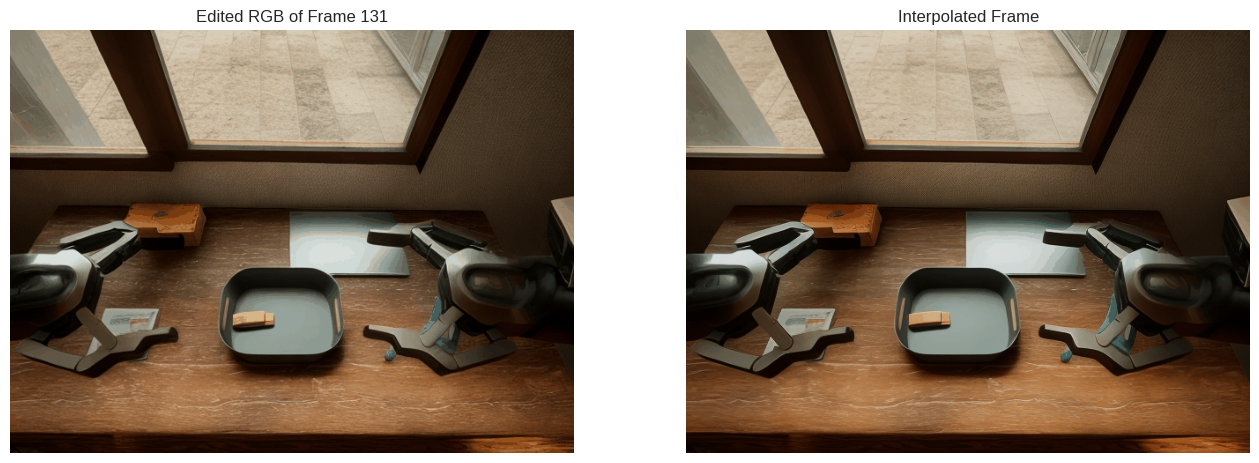

In [9]:
ANALYZE_INTERP = False
if ANALYZE_INTERP:
    idx = random.randint(1, N-1)
    # idx = 228  # 71, 228
    frames = dataset.edited_images
    s_frame = frames[idx-1:idx]
    m_frame = frames[idx:idx+1]
    e_frame = frames[idx+1:idx+2]

    with torch.no_grad():
        interp_frames_s = interpolater.inference(s_frame, m_frame)
        interp_frames_e = interpolater.inference(m_frame, e_frame)
        interp_frames_m = interpolater.inference(interp_frames_s, interp_frames_e)

    plt.style.use("seaborn-v0_8-whitegrid")
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(m_frame[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Edited RGB of Frame {idx}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(interp_frames_m[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f"Interpolated Frame")
    plt.axis("off")

    # plt.subplot(1, 3, 3)
    # plt.imshow(e_frame[0].permute(1, 2, 0).cpu().numpy())
    # plt.title(f"Edited of Frame {idx+1}")
    # plt.axis("off")

In [9]:
smooth_iteration = 20
smoothed_edited_images = dataset.edited_images

for k in tqdm(range(smooth_iteration), desc="Frames Smoothing"):
    edited_images = [smoothed_edited_images[0]]
    for i in range(1, N-1):
        s_frame = smoothed_edited_images[i-1:i]
        m_frame = smoothed_edited_images[i:i+1]
        e_frame = smoothed_edited_images[i+1:i+2]

        with torch.no_grad():
            interp_frames_s = interpolater.inference(s_frame, m_frame)
            interp_frames_e = interpolater.inference(m_frame, e_frame)
            interp_frames_m = interpolater.inference(interp_frames_s, interp_frames_e)

        edited_images.append(interp_frames_m[0])
    edited_images.append(smoothed_edited_images[-1])
    smoothed_edited_images = torch.stack(edited_images, dim=0)

# dataset.edited_images = smoothed_edited_images

# save_name = f"rife_smoothed_{smooth_iteration}"
# cur_output_path = os.path.join(output_dir, save_name)
# save_video(smoothed_edited_images, cur_output_path, save_frame=True, fps=15, gif=False)
# # copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
# os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
# os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

Frames Smoothing: 100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


In [ ]:
with torch.no_grad():
    # prepare depth estimation on original images
    depths_org = []
    for i in tqdm(range(0, len(org_frames)), desc="Estimating Depth on Original Images"):
        images = transform(org_frames[i:i+1].to(DEVICE))
        depths_org.append(depth_anything(images))
    depths_org = torch.stack(depths_org, dim=0)
    depths_org = F.interpolate(depths_org, (H, W), mode="bilinear", align_corners=True)

In [ ]:
def ssim_loss_func(x, y):
    x_norm = (x - x.min()) / (x.max() - x.min())
    y_norm = (y - y.min()) / (y.max() - y.min())
    return 1 - relaxed_ms_ssim(x_norm, y_norm, data_range=1, start_level=1)

In [46]:
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
start_time = datetime.datetime.now()
pbar.close()

with torch.no_grad():
    pil_tensor = dataset.edited_images.permute(0, 2, 3, 1).reshape(N*H*W, -1)
    # pil_tensor = torch_scatter.scatter(pil_tensor, data_parser.unq_inv, dim=0, reduce='mean')

    # prepare per-image confidence weights
    # loss_weight = relaxed_ms_ssim(org_frames, dataset.edited_images, data_range=1, start_level=1, size_average=False)
    # loss_weight = loss_weight / loss_weight.sum() * len(loss_weight)  # normalize to sum to N

fused_color = RGB2SH(pil_tensor)
features_dc = nn.Parameter(fused_color.contiguous().requires_grad_(True))

l = [
    {'params': [features_dc], 'lr': feature_lr, "name": "f_dc"},
]
optimizer = torch.optim.Adam(l, lr=0.0, eps=1e-15)

loss_list = []

pbar = tqdm(total=epochs, desc="Optimizing Unique Tensor")

for epoch in range(epochs):
    for i, (idxs, _edited_images, _, _past_flows, _mask_bwds) in enumerate(data_loader):

        step = epoch * len(frame_ids) // batch_size + i + 1
        _mask_bwds = _mask_bwds[idxs>0]
        cat_idxs = torch.cat([idxs, idxs-1], dim=0)
        cat_idxs[cat_idxs < 0] = 0

        # unq_inv = data_parser.unq_inv.reshape(N, H, W, -1)[cat_idxs].reshape(-1)
        # cat_images = SH2RGB(features_dc)[unq_inv].reshape(len(cat_idxs), H*W, -1) # N x HW x 3
        cat_images = SH2RGB(features_dc).reshape(N, H, W, -1)[cat_idxs]
        cat_images = torch.clamp(cat_images, 0, 1).reshape(len(cat_idxs), H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

        images = cat_images[:len(idxs)]
        pre_images = cat_images[len(idxs):]

        warped_images = warp_flow(pre_images, _past_flows)
        warped_images_m = warped_images[idxs>0]
        images_m = images[idxs>0]
        warped_images_m = warped_images_m * _mask_bwds.float()
        images_m = images_m * _mask_bwds.float()

        # plt.style.use("seaborn-v0_8-whitegrid")
        # plt.figure(figsize=(16, 10))
        # plt.subplot(1, 2, 1)
        # plt.imshow(images_m[0].permute(1, 2, 0).detach().cpu().numpy())
        # plt.title(f"Rendered RGB of Frame {idxs[0]}")
        # plt.axis("off")

        # plt.subplot(1, 2, 2)
        # plt.imshow(warped_images_m[0].permute(1, 2, 0).detach().cpu().numpy())
        # plt.title(f"Warped of Frame {idxs[0]}")
        # plt.axis("off")
        # break
        
        loss_flow = l1_loss(images_m, warped_images_m)
        # loss_flow = (1.0 - relaxed_ms_ssim(images_m, warped_images_m, data_range=1, start_level=1)) * lambda_dssim + \
        #             l1_loss(images_m, warped_images_m) * (1 - lambda_dssim)
        
        # 0. original
        loss_photometric = (1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, start_level=1)) * lambda_dssim + \
                            l1_loss(images, smoothed_edited_images[idxs]) * (1.0 - lambda_dssim)

        # 1. quantize images to relax the restriction
        # loss_ssim = (1.0 - ms_ssim(images, _edited_images, data_range=1)) * lambda_dssim
        # loss_ssim_org = (1.0 - ms_ssim(rgb_to_grayscale(images), rgb_to_grayscale(org_images[idxs]), data_range=1)) * lambda_dssim * 0.2
        # loss_photometric = loss_ssim + loss_ssim_org

        # 2. weight the ssim loss with per-image confidence
        # loss_photometric = ((1.0 - relaxed_ms_ssim(images, _edited_images, data_range=1, 
        #                     start_level=1, size_average=False)) * loss_weight[idxs]).mean() * lambda_dssim

        # 3. weight the ssim loss with per-pixel confidence
        # loss_ssim = (1.0 - weighted_ms_ssim(images, _edited_images, org_frames[idxs], data_range=1, start_level=1)) * lambda_dssim
        
        # 4. use perceptual loss as supervision
        # loss_photometric = vgg_loss(images, _edited_images) * lambda_perceptual

        # 5. use depth estimation as supervision
        # depth_weight = get_weight(step, iterations, lambda_depth, d_final_factor)
        # depths = depth_anything(transform(images))
        # depths = F.interpolate(depths[:, None], (H, W), mode="bilinear", align_corners=True).squeeze()
        # loss_photometric = depth_loss_dpt(depths[:, None], depths_org[idxs], ssim_loss_func) * depth_weight

        # 6. use TV loss as regularization
        # loss_tv = tv_loss(images)

        loss = (1 - lambda_flow) * loss_photometric + lambda_flow * loss_flow

        loss_list.append([loss.item(), loss_photometric.item(), loss_flow.item()])

        loss.backward()

        optimizer.step()
        optimizer.zero_grad(set_to_none = True)
    
    pbar.set_postfix(
        loss='{:3f}'.format(loss.item()), 
        loss_flow='{:3f}'.format(loss_flow.item()),
        loss_photometric='{:3f}'.format(loss_photometric.item())
    )
    pbar.update()

pbar.close()

end_time = datetime.datetime.now()
max_memory_allocated = torch.cuda.max_memory_allocated() / (1024.0 ** 2)
print(f"Memory: {max_memory_allocated:.2f} MB")
print(f"Time: {(end_time - start_time).total_seconds()}s")

# images = SH2RGB(features_dc)[data_parser.unq_inv].reshape(N, H*W, -1) # N x HW x 3
images = SH2RGB(features_dc).reshape(N, H*W, -1) # N x HW x 3
images = torch.clamp(images, 0, 1).reshape(N, H, W, 3).permute(0, 3, 1, 2)  # N x 3 x H x W

Optimizing Unique Tensor:   0%|          | 0/70 [00:00<?, ?it/s]

Optimizing Unique Tensor: 100%|██████████| 70/70 [00:43<00:00,  1.62it/s, loss=0.007689, loss_flow=0.007515, loss_photometric=0.007951]

Memory: 10958.54 MB
Time: 43.252814s


Text(0.5, 1.0, 'Loss curve for unique tensor optimization')

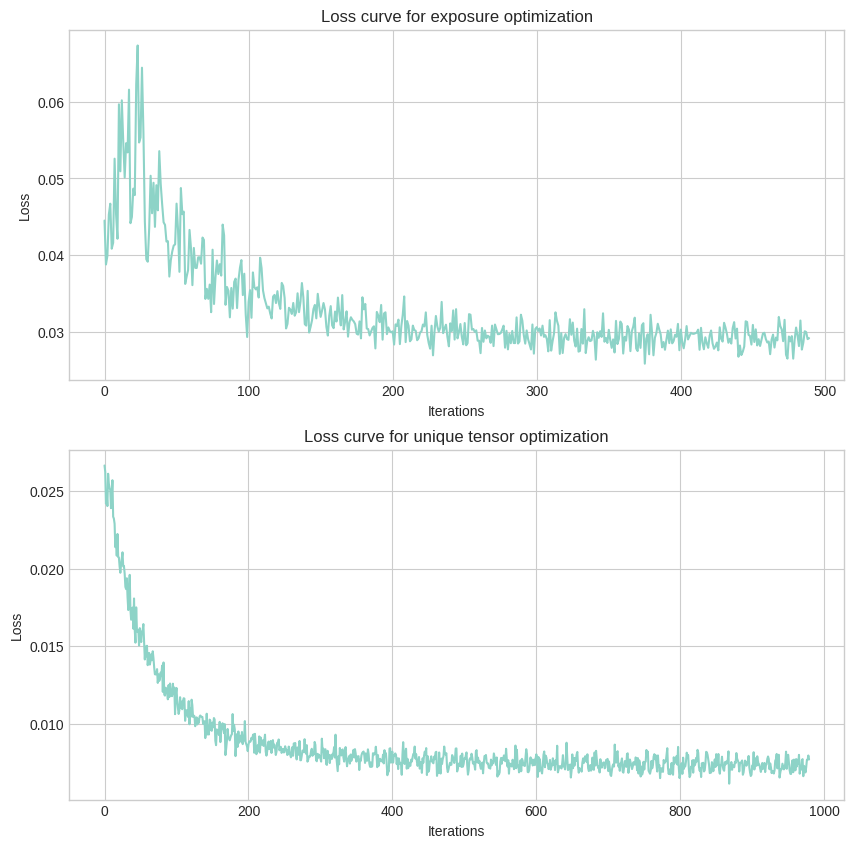

In [47]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(loss_list_exposure)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for exposure optimization")

plt.subplot(2, 1, 2)
plt.plot(np.array(loss_list)[:, 0])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss curve for unique tensor optimization")

In [50]:
# save_name = f"opt_lr_{feature_lr:3f}_lambda_flow_{lambda_flow}_lambda_exp_{lambda_exp}_ssim_{lambda_dssim}_slevel1_ep{epochs}_loss_{loss_list[-1]:.3f}"
save_name = f"opt_full_tensor_lr_{feature_lr:3f}_lambda_flow_{lambda_flow}_lambda_exp_{lambda_exp}_depth_{lambda_depth}_final_{d_final_factor}_tmp_slevel1_ep{epochs}_loss_{loss_list[-1][0]:.3f}"
cur_output_path = os.path.join(output_dir, save_name)
save_video(images, cur_output_path, save_frame=True, fps=15)
# copy output_dir/config.yaml and output_dir/output_gt.gif to cur_output_path
os.system(f"cp {os.path.join(output_dir, 'config.yaml')} {cur_output_path}")
os.system(f"cp {os.path.join(output_dir, 'output_gt.gif')} {cur_output_path}")

[INFO] save video to ../workdir/agirobot_digital/agirobot_digitaltwin_5_natural_lmr_0.9_gmr_0.8_vox_None/opt_full_tensor_lr_0.003620_lambda_flow_0.6_lambda_exp_0.8_depth_1.0_final_0.1_tmp_slevel1_ep70_loss_0.008/output.gif


0

In [10]:
images_np = images.permute(0, 2, 3, 1).detach().cpu().numpy()
edited_images_np = dataset.edited_images.permute(0, 2, 3, 1).cpu().numpy()
smoothed_edited_images_np = smoothed_edited_images.permute(0, 2, 3, 1).cpu().numpy()
# org_images_np = org_frames.permute(0, 2, 3, 1).cpu().numpy()

(-0.5, 639.5, 479.5, -0.5)

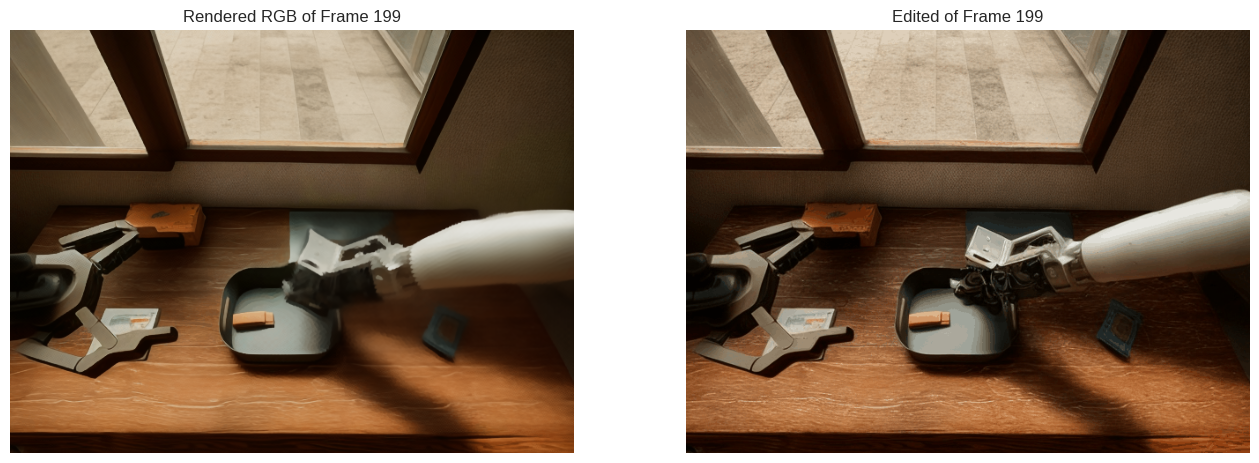

In [12]:
plt.style.use("seaborn-v0_8-whitegrid")
idx = random.randint(0, N-1)
idx = 199

# with torch.no_grad():
#     mask_bwd = dataset.mask_bwd[idx:idx+1]
#     warped_images = warp_flow(images[idx-1:idx], dataset.past_flows[idx:idx+1])
#     warped_images[~mask_bwd] = 0
#     warped_images = warped_images.permute(0, 2, 3, 1).cpu().numpy()
#     warped_images = np.clip(warped_images[0], 0, 1)

plt.figure(figsize=(16, 10))
plt.subplot(1, 2, 1)
plt.imshow(smoothed_edited_images_np[idx])
plt.title(f"Rendered RGB of Frame {idx}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited_images_np[idx])
plt.title(f"Edited of Frame {idx}")
# plt.imshow(warped_images)
# plt.title(f"Warped of Frame {idx}")
plt.axis("off")